# 13.3a: Monument Valley Simulation

**Goal:** Test the Monument Valley hypothesis - does random survival from a large Gaussian initialization produce Qwen's black hole demographics?

## The Question

Qwen has 13 black holes with populations [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2].

**Monument Valley hypothesis:**
1. Initialize 151,936 tokens with Gaussian(centroid, σ) in float32
2. Quantize to bfloat16 → creates natural clustering
3. **Uniformly delete 149,715 tokens** (simulating random training selection)
4. Measure demographics of the 2,221 survivors

The key difference from previous synthetic snowball work:
- **Previous:** Sample 2,221 tokens → quantize
- **Monument Valley:** Sample 151,936 tokens → quantize → **uniformly delete most**

Black hole size distribution depends on:
- How many tokens initially land in each bfloat16 cell (Gaussian density)
- Probability that ≥1 token in that cell survives (binomial with p=2221/151936)

We'll sweep σ values in a specified range and see if any match Qwen's demographics.

## Parameters

In [14]:
# Input
DEAD_TOKENS_PATH = "../data/tensors/13.1a_dead_tokens.safetensors"

# Monument Valley parameters
N_TOTAL_TOKENS = 151936  # Full vocabulary
N_SURVIVORS = 2221       # Match Qwen's dead token count exactly
N_DIMS = 2560

# Sigma sweep range (log-spaced between min and max)
SIGMA_MIN = 1.4e-9
SIGMA_MAX = 1.6e-9
N_SIGMA_SAMPLES = 30  # Number of sigma values to test

# Trials per sigma
N_TRIALS_PER_SIGMA = 10

# Output
OUTPUT_PATH = "../data/tensors/13.3a_monument_valley_results.safetensors"

# Figure settings
DPI = 150

RANDOM_SEED = 42

## Imports

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file, save_file
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Check for MPS
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
print("✓ Imports complete")

Using device: mps
✓ Imports complete


## Generate Sigma Values

In [16]:
# Generate log-spaced sigma values
SIGMA_VALUES = np.logspace(np.log10(SIGMA_MIN), np.log10(SIGMA_MAX), N_SIGMA_SAMPLES).tolist()

print(f"\nSigma sweep range:")
print(f"  Min: {SIGMA_MIN:.2e}")
print(f"  Max: {SIGMA_MAX:.2e}")
print(f"  Samples: {N_SIGMA_SAMPLES}")
print(f"\nSigma values:")
for i, sigma in enumerate(SIGMA_VALUES):
    print(f"  [{i+1:2d}] {sigma:.6e}")


Sigma sweep range:
  Min: 1.40e-09
  Max: 1.60e-09
  Samples: 30

Sigma values:
  [ 1] 1.400000e-09
  [ 2] 1.406461e-09
  [ 3] 1.412952e-09
  [ 4] 1.419473e-09
  [ 5] 1.426024e-09
  [ 6] 1.432606e-09
  [ 7] 1.439217e-09
  [ 8] 1.445859e-09
  [ 9] 1.452532e-09
  [10] 1.459236e-09
  [11] 1.465971e-09
  [12] 1.472736e-09
  [13] 1.479533e-09
  [14] 1.486361e-09
  [15] 1.493221e-09
  [16] 1.500113e-09
  [17] 1.507036e-09
  [18] 1.513991e-09
  [19] 1.520978e-09
  [20] 1.527998e-09
  [21] 1.535050e-09
  [22] 1.542134e-09
  [23] 1.549252e-09
  [24] 1.556402e-09
  [25] 1.563585e-09
  [26] 1.570801e-09
  [27] 1.578050e-09
  [28] 1.585333e-09
  [29] 1.592650e-09
  [30] 1.600000e-09


## Load Qwen Dead Token Data (for centroid)

In [17]:
print("\nLoading Qwen dead token data...\n")

data = load_file(DEAD_TOKENS_PATH)
qwen_centroid = data['weighted_centroid'].to(device)
qwen_embeddings = data['dead_embeddings_float32']

# Get Qwen's black hole demographics for comparison
qwen_unique, qwen_inverse, qwen_counts = torch.unique(
    qwen_embeddings, dim=0, return_inverse=True, return_counts=True
)
qwen_bh_counts = qwen_counts[qwen_counts >= 2]
qwen_demographics = torch.sort(qwen_bh_counts, descending=True)[0].tolist()

print(f"✓ Loaded centroid: {qwen_centroid.shape}")
print(f"  Centroid norm: {torch.norm(qwen_centroid, p=2).item():.6f}")
print(f"\nQwen demographics (target):")
print(f"  {qwen_demographics}")
print(f"  n_black_holes: {len(qwen_demographics)}")
print(f"  largest_bh: {qwen_demographics[0]}")


Loading Qwen dead token data...

✓ Loaded centroid: torch.Size([2560])
  Centroid norm: 0.370917

Qwen demographics (target):
  [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]
  n_black_holes: 13
  largest_bh: 814


## Monument Valley Simulation Function

In [18]:
def run_monument_valley_trial(sigma, centroid):
    """
    Run one Monument Valley trial at given sigma.
    
    Args:
        sigma: Standard deviation for Gaussian noise
        centroid: Center point for initialization (on MPS)
    
    Returns:
        dict with statistics
    """
    # 1. Initialize 151,936 tokens on MPS
    init_f32 = centroid + torch.randn(N_TOTAL_TOKENS, N_DIMS, device=device) * sigma
    
    # 2. Quantize to bfloat16 (on MPS)
    init_bf16 = init_f32.to(torch.bfloat16)
    
    # 3. Uniformly sample N_SURVIVORS indices
    survivor_indices = torch.randperm(N_TOTAL_TOKENS, device=device)[:N_SURVIVORS]
    survivors = init_bf16[survivor_indices]  # [N_SURVIVORS, N_DIMS]
    
    # 4. Move to CPU for unique processing
    survivors_cpu = survivors.to('cpu', dtype=torch.float32)
    
    # 5. Get unique vectors and demographics
    unique, inverse, counts = torch.unique(
        survivors_cpu, dim=0, return_inverse=True, return_counts=True
    )
    
    n_unique = len(unique)
    n_singletons = (counts == 1).sum().item()
    
    # Black hole demographics
    bh_mask = counts >= 2
    bh_counts = counts[bh_mask]
    
    if len(bh_counts) > 0:
        sorted_bh_counts = torch.sort(bh_counts, descending=True)[0]
        n_black_holes = len(sorted_bh_counts)
        largest_bh = sorted_bh_counts[0].item()
        demographics = sorted_bh_counts.tolist()
    else:
        n_black_holes = 0
        largest_bh = 0
        demographics = []
    
    return {
        'n_unique': n_unique,
        'n_singletons': n_singletons,
        'n_black_holes': n_black_holes,
        'largest_bh': largest_bh,
        'demographics': demographics,
    }

print("✓ Defined Monument Valley trial function")

✓ Defined Monument Valley trial function


## Run Sigma Sweep

In [19]:
print(f"\nRunning Monument Valley simulation...\n")
print(f"Parameters:")
print(f"  Total tokens: {N_TOTAL_TOKENS:,}")
print(f"  Survivors: {N_SURVIVORS:,}")
print(f"  Survival rate: {N_SURVIVORS/N_TOTAL_TOKENS*100:.2f}%")
print(f"  Sigma values: {len(SIGMA_VALUES)}")
print(f"  Trials per sigma: {N_TRIALS_PER_SIGMA}\n")

# Storage for results
all_results = {}  # sigma -> list of trial results

# Sweep over sigma values
for sigma in tqdm(SIGMA_VALUES, desc="Sigma sweep"):
    sigma_results = []
    
    # Run trials
    for trial_idx in tqdm(range(N_TRIALS_PER_SIGMA), desc=f"σ={sigma:.1e}", leave=False):
        result = run_monument_valley_trial(sigma=sigma, centroid=qwen_centroid)
        sigma_results.append(result)
    
    all_results[sigma] = sigma_results

print(f"\n✓ Completed {len(SIGMA_VALUES)} sigma values × {N_TRIALS_PER_SIGMA} trials each")


Running Monument Valley simulation...

Parameters:
  Total tokens: 151,936
  Survivors: 2,221
  Survival rate: 1.46%
  Sigma values: 30
  Trials per sigma: 10



Sigma sweep: 100%|██████████| 30/30 [00:22<00:00,  1.35it/s]


✓ Completed 30 sigma values × 10 trials each


## Aggregate Statistics Per Sigma

In [20]:
print("\nAggregating statistics...\n")

summary_stats = []

for sigma in SIGMA_VALUES:
    results = all_results[sigma]
    
    # Extract arrays
    n_unique_arr = np.array([r['n_unique'] for r in results])
    n_singletons_arr = np.array([r['n_singletons'] for r in results])
    n_black_holes_arr = np.array([r['n_black_holes'] for r in results])
    largest_bh_arr = np.array([r['largest_bh'] for r in results])
    
    # Compute summary
    summary = {
        'sigma': sigma,
        'n_unique_mean': n_unique_arr.mean(),
        'n_unique_std': n_unique_arr.std(),
        'n_singletons_mean': n_singletons_arr.mean(),
        'n_singletons_std': n_singletons_arr.std(),
        'n_black_holes_mean': n_black_holes_arr.mean(),
        'n_black_holes_std': n_black_holes_arr.std(),
        'largest_bh_mean': largest_bh_arr.mean(),
        'largest_bh_std': largest_bh_arr.std(),
    }
    
    summary_stats.append(summary)

print(f"✓ Aggregated statistics for {len(SIGMA_VALUES)} sigma values")


Aggregating statistics...

✓ Aggregated statistics for 30 sigma values


## Display Summary Table

In [21]:
print(f"\n{'='*100}")
print(f"MONUMENT VALLEY RESULTS SUMMARY")
print(f"{'='*100}\n")

print(f"Qwen targets:")
print(f"  n_black_holes: {len(qwen_demographics)}")
print(f"  largest_bh: {qwen_demographics[0]}")
print(f"  demographics: {qwen_demographics}\n")

print(f"{'Sigma':>12} {'n_BH':>8} {'largest_BH':>12} {'n_unique':>10} {'n_single':>10}")
print("-" * 100)

for stats in summary_stats:
    sigma = stats['sigma']
    n_bh = stats['n_black_holes_mean']
    n_bh_std = stats['n_black_holes_std']
    largest = stats['largest_bh_mean']
    largest_std = stats['largest_bh_std']
    n_unique = stats['n_unique_mean']
    n_single = stats['n_singletons_mean']
    
    # Highlight if close to Qwen
    marker = ""
    if abs(n_bh - len(qwen_demographics)) < 2 and abs(largest - qwen_demographics[0]) < 100:
        marker = " ← MATCH"
    
    print(f"{sigma:>12.6e} {n_bh:>5.1f}±{n_bh_std:<4.1f} {largest:>6.0f}±{largest_std:<5.0f} {n_unique:>7.1f} {n_single:>7.1f}{marker}")

print(f"\n{'='*100}")


MONUMENT VALLEY RESULTS SUMMARY

Qwen targets:
  n_black_holes: 13
  largest_bh: 814
  demographics: [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]

       Sigma     n_BH   largest_BH   n_unique   n_single
----------------------------------------------------------------------------------------------------
1.400000e-09   4.9±0.5    1664±17        5.5     0.6
1.406461e-09   5.1±0.7    1646±20        5.8     0.7
1.412952e-09   5.2±0.6    1660±10        5.7     0.5
1.419473e-09   5.4±0.7    1650±19        6.0     0.6
1.426024e-09   5.4±0.7    1650±21        5.8     0.4
1.432606e-09   5.4±0.7    1644±26        5.8     0.4
1.439217e-09   4.9±0.7    1640±15        5.7     0.8
1.445859e-09   5.6±0.5    1650±19        6.0     0.4
1.452532e-09   5.2±0.4    1639±15        5.9     0.7
1.459236e-09   5.5±0.5    1640±18        5.7     0.2
1.465971e-09   5.7±0.5    1634±19        5.9     0.2
1.472736e-09   5.5±0.5    1639±29        5.9     0.4
1.479533e-09   5.6±0.5    1626±16        6.0     0.4


## Figure 1: Summary Statistics vs Sigma

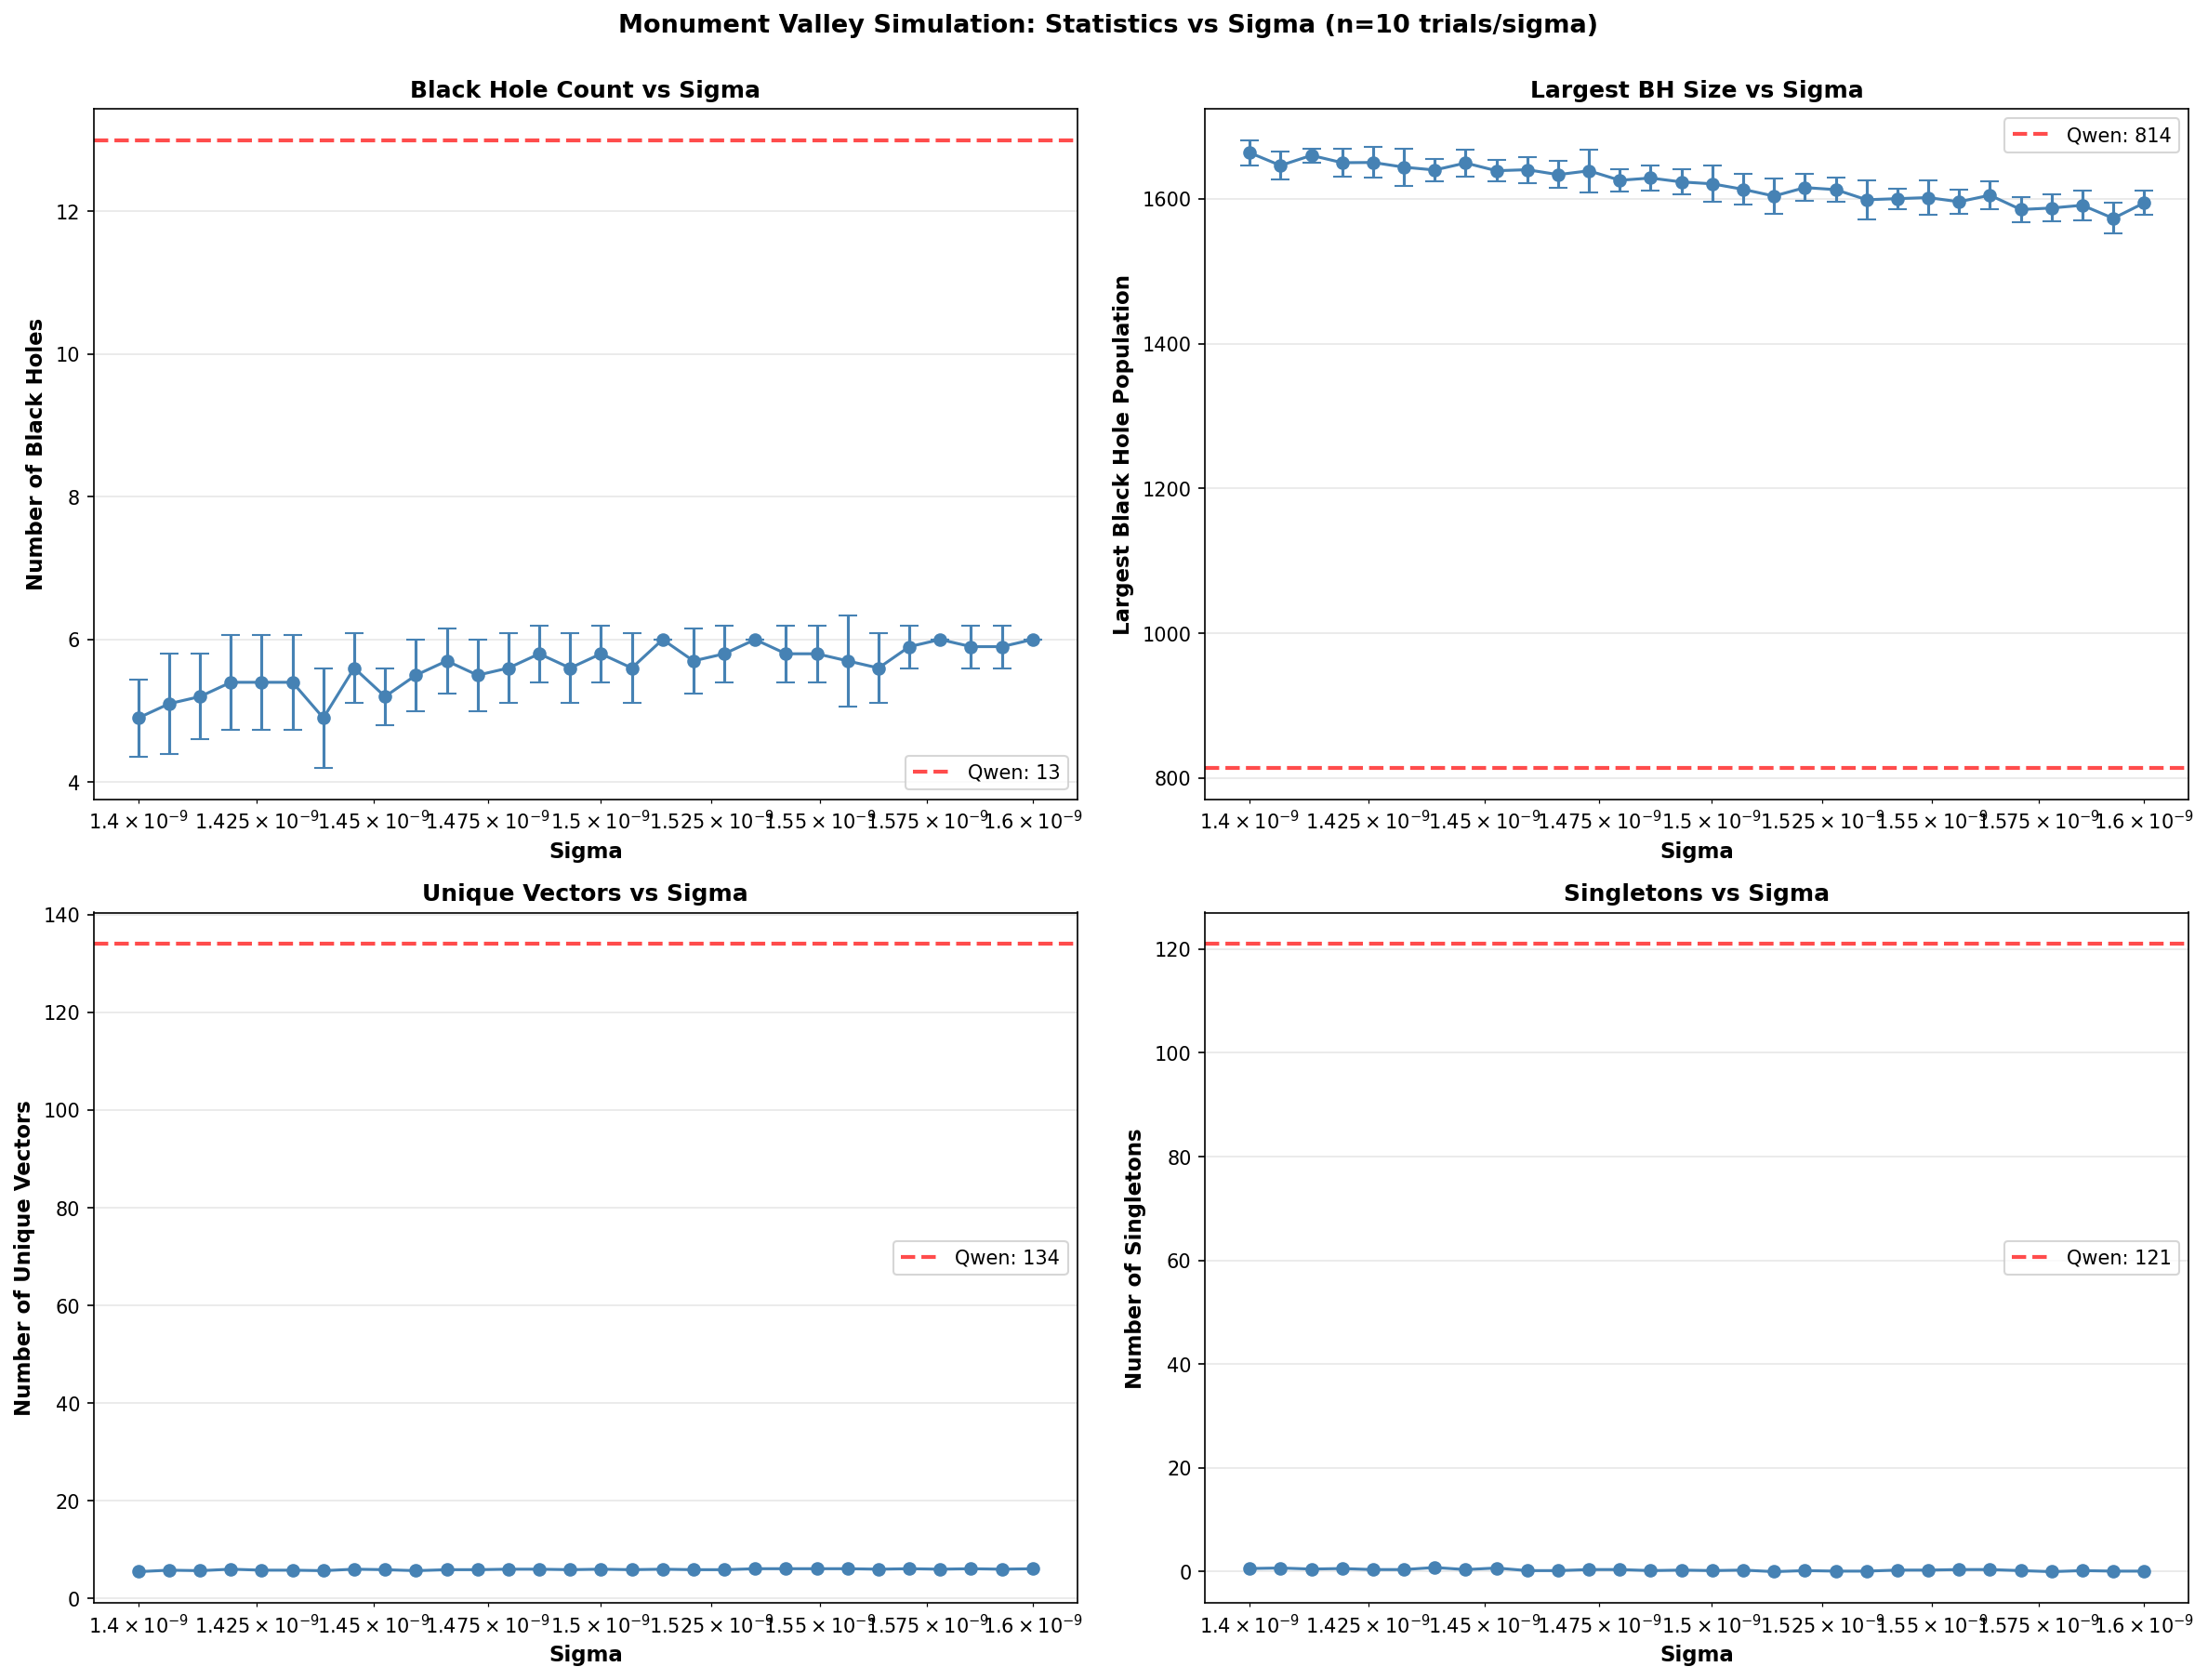

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=DPI)

sigmas = [s['sigma'] for s in summary_stats]

# Top-left: Number of black holes
ax = axes[0, 0]
n_bh_means = [s['n_black_holes_mean'] for s in summary_stats]
n_bh_stds = [s['n_black_holes_std'] for s in summary_stats]
ax.errorbar(sigmas, n_bh_means, yerr=n_bh_stds, marker='o', linestyle='-', capsize=5, color='steelblue')
ax.axhline(len(qwen_demographics), color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Qwen: {len(qwen_demographics)}')
ax.set_xlabel('Sigma', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Black Holes', fontsize=11, fontweight='bold')
ax.set_title('Black Hole Count vs Sigma', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Top-right: Largest black hole size
ax = axes[0, 1]
largest_means = [s['largest_bh_mean'] for s in summary_stats]
largest_stds = [s['largest_bh_std'] for s in summary_stats]
ax.errorbar(sigmas, largest_means, yerr=largest_stds, marker='o', linestyle='-', capsize=5, color='steelblue')
ax.axhline(qwen_demographics[0], color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Qwen: {qwen_demographics[0]}')
ax.set_xlabel('Sigma', fontsize=11, fontweight='bold')
ax.set_ylabel('Largest Black Hole Population', fontsize=11, fontweight='bold')
ax.set_title('Largest BH Size vs Sigma', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Bottom-left: Number of unique vectors
ax = axes[1, 0]
n_unique_means = [s['n_unique_mean'] for s in summary_stats]
ax.plot(sigmas, n_unique_means, marker='o', linestyle='-', color='steelblue')
ax.axhline(134, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Qwen: 134')
ax.set_xlabel('Sigma', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Unique Vectors', fontsize=11, fontweight='bold')
ax.set_title('Unique Vectors vs Sigma', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Bottom-right: Number of singletons
ax = axes[1, 1]
n_single_means = [s['n_singletons_mean'] for s in summary_stats]
ax.plot(sigmas, n_single_means, marker='o', linestyle='-', color='steelblue')
ax.axhline(121, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Qwen: 121')
ax.set_xlabel('Sigma', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Singletons', fontsize=11, fontweight='bold')
ax.set_title('Singletons vs Sigma', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle(f'Monument Valley Simulation: Statistics vs Sigma (n={N_TRIALS_PER_SIGMA} trials/sigma)',
             fontsize=13, fontweight='bold', y=1.00)

plt.tight_layout()
plt.show()

## Find Best Matching Sigma

In [23]:
print("\nFinding best matching sigma...\n")

# Score each sigma by how close it is to Qwen's targets
# Use normalized distance in (n_black_holes, largest_bh) space

qwen_n_bh = len(qwen_demographics)
qwen_largest = qwen_demographics[0]

best_sigma = None
best_distance = float('inf')

for stats in summary_stats:
    sigma = stats['sigma']
    n_bh = stats['n_black_holes_mean']
    largest = stats['largest_bh_mean']
    
    # Normalized distance (each component scaled by target value)
    dist_n_bh = abs(n_bh - qwen_n_bh) / qwen_n_bh
    dist_largest = abs(largest - qwen_largest) / qwen_largest
    
    total_dist = np.sqrt(dist_n_bh**2 + dist_largest**2)
    
    if total_dist < best_distance:
        best_distance = total_dist
        best_sigma = sigma
        best_stats = stats

print(f"Best matching sigma: {best_sigma:.6e}")
print(f"  n_black_holes: {best_stats['n_black_holes_mean']:.1f} ± {best_stats['n_black_holes_std']:.1f} (target: {qwen_n_bh})")
print(f"  largest_bh: {best_stats['largest_bh_mean']:.0f} ± {best_stats['largest_bh_std']:.0f} (target: {qwen_largest})")
print(f"  n_unique: {best_stats['n_unique_mean']:.1f} (target: 134)")
print(f"  n_singletons: {best_stats['n_singletons_mean']:.1f} (target: 121)")
print(f"\nNormalized distance from Qwen: {best_distance:.4f}")


Finding best matching sigma...

Best matching sigma: 1.592650e-09
  n_black_holes: 5.9 ± 0.3 (target: 13)
  largest_bh: 1573 ± 21 (target: 814)
  n_unique: 6.0 (target: 134)
  n_singletons: 0.1 (target: 121)

Normalized distance from Qwen: 1.0807


## Examine Demographics at Best Sigma

In [24]:
print(f"\nExamining demographics at best sigma ({best_sigma:.6e})...\n")

best_results = all_results[best_sigma]

# Collect all demographics lists
all_demographics = [r['demographics'] for r in best_results]

# Show a few examples
print("Example demographics from trials:\n")
for i in range(min(10, len(all_demographics))):
    demo = all_demographics[i]
    print(f"  Trial {i+1}: {demo[:10]}{'...' if len(demo) > 10 else ''}")

print(f"\nQwen (target): {qwen_demographics}")

# Find trial with demographics closest to Qwen
def compare_demographics(demo1, demo2):
    """Simple distance: sum of absolute differences in first N elements."""
    n = min(len(demo1), len(demo2))
    if n == 0:
        return float('inf')
    
    dist = sum(abs(demo1[i] - demo2[i]) for i in range(n))
    # Penalize length mismatch
    dist += abs(len(demo1) - len(demo2)) * 100
    return dist

closest_idx = None
closest_dist = float('inf')

for i, demo in enumerate(all_demographics):
    dist = compare_demographics(demo, qwen_demographics)
    if dist < closest_dist:
        closest_dist = dist
        closest_idx = i

print(f"\nClosest match to Qwen (trial {closest_idx+1}):")
print(f"  {all_demographics[closest_idx]}")
print(f"  Distance: {closest_dist:.0f}")


Examining demographics at best sigma (1.592650e-09)...

Example demographics from trials:

  Trial 1: [1591, 582, 23, 16, 8]
  Trial 2: [1568, 604, 27, 9, 9, 4]
  Trial 3: [1571, 599, 23, 13, 11, 4]
  Trial 4: [1583, 595, 20, 11, 8, 4]
  Trial 5: [1578, 597, 22, 12, 10, 2]
  Trial 6: [1533, 630, 25, 16, 10, 7]
  Trial 7: [1551, 627, 20, 14, 5, 4]
  Trial 8: [1617, 568, 13, 12, 6, 5]
  Trial 9: [1572, 608, 18, 14, 6, 3]
  Trial 10: [1567, 611, 19, 14, 8, 2]

Qwen (target): [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]

Closest match to Qwen (trial 6):
  [1533, 630, 25, 16, 10, 7]
  Distance: 1990


## Save Results

In [25]:
print("\nSaving results...\n")

# Prepare tensors for saving
save_dict = {
    'sigma_min': torch.tensor(SIGMA_MIN, dtype=torch.float32),
    'sigma_max': torch.tensor(SIGMA_MAX, dtype=torch.float32),
    'n_sigma_samples': torch.tensor(N_SIGMA_SAMPLES, dtype=torch.int64),
    'sigma_values': torch.tensor(SIGMA_VALUES, dtype=torch.float32),
    'n_trials_per_sigma': torch.tensor(N_TRIALS_PER_SIGMA, dtype=torch.int64),
    'n_black_holes_mean': torch.tensor([s['n_black_holes_mean'] for s in summary_stats], dtype=torch.float32),
    'n_black_holes_std': torch.tensor([s['n_black_holes_std'] for s in summary_stats], dtype=torch.float32),
    'largest_bh_mean': torch.tensor([s['largest_bh_mean'] for s in summary_stats], dtype=torch.float32),
    'largest_bh_std': torch.tensor([s['largest_bh_std'] for s in summary_stats], dtype=torch.float32),
    'n_unique_mean': torch.tensor([s['n_unique_mean'] for s in summary_stats], dtype=torch.float32),
    'n_singletons_mean': torch.tensor([s['n_singletons_mean'] for s in summary_stats], dtype=torch.float32),
    'best_sigma': torch.tensor(best_sigma, dtype=torch.float32),
}

save_file(save_dict, OUTPUT_PATH)

print(f"✓ Saved to {OUTPUT_PATH}")
print(f"\nSaved tensors:")
for key in save_dict.keys():
    tensor = save_dict[key]
    if tensor.ndim == 0:
        print(f"  {key}: scalar = {tensor.item()}")
    else:
        print(f"  {key}: shape={tensor.shape}, dtype={tensor.dtype}")


Saving results...

✓ Saved to ../data/tensors/13.3a_monument_valley_results.safetensors

Saved tensors:
  sigma_min: scalar = 1.400000004814217e-09
  sigma_max: scalar = 1.6000000213622911e-09
  n_sigma_samples: scalar = 30
  sigma_values: shape=torch.Size([30]), dtype=torch.float32
  n_trials_per_sigma: scalar = 10
  n_black_holes_mean: shape=torch.Size([30]), dtype=torch.float32
  n_black_holes_std: shape=torch.Size([30]), dtype=torch.float32
  largest_bh_mean: shape=torch.Size([30]), dtype=torch.float32
  largest_bh_std: shape=torch.Size([30]), dtype=torch.float32
  n_unique_mean: shape=torch.Size([30]), dtype=torch.float32
  n_singletons_mean: shape=torch.Size([30]), dtype=torch.float32
  best_sigma: scalar = 1.5926496788054578e-09


## Summary

In [26]:
print(f"\n{'='*100}")
print(f"MONUMENT VALLEY SIMULATION COMPLETE")
print(f"{'='*100}")
print(f"\nHypothesis tested:")
print(f"  Initialize {N_TOTAL_TOKENS:,} tokens with Gaussian(centroid, σ)")
print(f"  Quantize to bfloat16")
print(f"  Uniformly delete {N_TOTAL_TOKENS - N_SURVIVORS:,} tokens (simulate random training)")
print(f"  Measure demographics of {N_SURVIVORS:,} survivors")
print(f"\nSigma sweep:")
print(f"  Range: {SIGMA_MIN:.2e} to {SIGMA_MAX:.2e}")
print(f"  Samples: {N_SIGMA_SAMPLES} (log-spaced)")
print(f"  {N_TRIALS_PER_SIGMA} trials per sigma")
print(f"  Total trials: {len(SIGMA_VALUES) * N_TRIALS_PER_SIGMA:,}")
print(f"\nBest match: σ = {best_sigma:.6e}")
print(f"  n_black_holes: {best_stats['n_black_holes_mean']:.1f} ± {best_stats['n_black_holes_std']:.1f} (Qwen: {qwen_n_bh})")
print(f"  largest_bh: {best_stats['largest_bh_mean']:.0f} ± {best_stats['largest_bh_std']:.0f} (Qwen: {qwen_largest})")
print(f"\nNext steps:")
print(f"  - Narrow sigma range around {best_sigma:.2e} for finer resolution")
print(f"  - Compare full demographics distribution at best sigma")
print(f"  - Test if Monument Valley reproduces spatial extent (L∞ distances)")
print(f"\n{'='*100}")


MONUMENT VALLEY SIMULATION COMPLETE

Hypothesis tested:
  Initialize 151,936 tokens with Gaussian(centroid, σ)
  Quantize to bfloat16
  Uniformly delete 149,715 tokens (simulate random training)
  Measure demographics of 2,221 survivors

Sigma sweep:
  Range: 1.40e-09 to 1.60e-09
  Samples: 30 (log-spaced)
  10 trials per sigma
  Total trials: 300

Best match: σ = 1.592650e-09
  n_black_holes: 5.9 ± 0.3 (Qwen: 13)
  largest_bh: 1573 ± 21 (Qwen: 814)

Next steps:
  - Narrow sigma range around 1.59e-09 for finer resolution
  - Compare full demographics distribution at best sigma
  - Test if Monument Valley reproduces spatial extent (L∞ distances)

